In [16]:
import torch
import torch.nn as nn
import numpy as np
import torch.utils.data as data
import torch.nn.functional as F
import os, glob
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from packages.visual_utils import *
from packages.data_utils import *
from packages.training import Pangolin, PangolinEXP
from lightning.pytorch import Trainer
from packages.training_lighting import PangolinLitModule  # adjust import as needed
from sklearn.metrics import precision_recall_curve, average_precision_score

# Constants
L_DIM = 32
W = np.asarray([11]*8 + [21]*4 + [41]*4)
AR = np.asarray([1]*4 + [4]*4 + [10]*4 + [25]*4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [2]:
#!aws s3 ls s3://research.luffingfuturellc/Pangolin/
#!aws s3 cp s3://research.luffingfuturellc/Pangolin/20Samples_exp_model_epochepoch=299.ckpt ./Model/

In [3]:
#cuda.close()
list_model = glob.glob("Model/*.ckpt")
print (list_model)
# Load model from .ckpt
model = PangolinLitModule.load_from_checkpoint(
    checkpoint_path="Model/20Samples_exp_model_epochepoch=299.ckpt", L=L_DIM, W=W, AR=AR)

['Model/20Samples_exp_model_epochepoch=299.ckpt']


In [17]:
#Load the Pretrained Model
#seq_model = PangolinEXP(L=L_DIM, W=W, AR=AR)
#model = Pangolin(L=L_DIM, W=W, AR=AR)
#model_path = 'Model/20Samples_training_data_sequece_exp_model.pt'
#model_path = 'Model/final.5.7.3.pt'
#state_dict = torch.load(model_path, map_location=device, weights_only=True)
#model.load_state_dict(state_dict)

In [10]:
# Move model to GPU################
model.to(device)
###################################
# ⛳ CRITICAL: Check device of model weights
print("Model device:", next(model.parameters()).device)

# Load preprocessed training data
data = torch.load("20Samples_training_data_sequece_exp.pt", weights_only=True)
#data = torch.load("gene_merged_training_data.pt", weights_only=True)
training_input =  torch.stack(data['X'])  # Each: [N, 4, 15000] # Input:
training_label = torch.stack(data['y'])  # Each: [N, 12, 5000] # Label:
print("Loading Data: ", len(training_input))
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

#pred = seq_model(training_input[0:50, :4, :].to(device)).detach().cpu()[:, 0:3, :]
with torch.no_grad():
    pred = model(training_input.to(device)).to(device).detach().cpu()

Model device: cuda:0
Loading Data:  269


In [22]:
## Metrics for Model Performace
def weighted_peak_correlation_score(pred, target, peak_threshold=0.1, weight_power=2.0, epsilon=1e-6):
    """
    Measures how well predicted usage scores match ground-truth usage peaks.
    
    Args:
        pred: Tensor of shape [batch, 1, L] – predicted usage
        target: Tensor of shape [batch, 1, L] – ground-truth usage
        peak_threshold: float – threshold above which a target is considered a true peak
        weight_power: float – exponent to emphasize higher-usage regions
    Returns:
        Average WPCS across batch.
    """
    assert pred.shape == target.shape, "Pred and target must have same shape"
    
    batch_scores = []
    for i in range(pred.size(0)):
        p = pred[i, 2]
        t = target[i, 2]

        # Focus on regions with significant usage in ground-truth
        mask = t > peak_threshold
        if mask.sum() == 0:
            batch_scores.append(torch.tensor(1.0, device=pred.device))  # Empty peak = trivially perfect
            continue

        # Weighted correlation components
        t_weighted = t[mask] ** weight_power
        p_weighted = p[mask] ** weight_power

        t_mean = t_weighted.mean()
        p_mean = p_weighted.mean()

        numerator = ((t_weighted - t_mean) * (p_weighted - p_mean)).sum()
        denominator = torch.sqrt(((t_weighted - t_mean) ** 2).sum() * ((p_weighted - p_mean) ** 2).sum())
        #print (numerator, denominator)
        score = numerator / (denominator + epsilon)  # Prevent division by 0
        batch_scores.append(score)
    
    return torch.stack(batch_scores).mean()

def pearson_corr(pred, target):
    pred = pred[:, 2].flatten()
    target = target[:, 2].flatten()
    cov = ((pred - pred.mean()) * (target - target.mean())).mean()
    std_pred = pred.std()
    std_target = target.std()
    return (cov / (std_pred * std_target + 1e-6)).item()

def usage_peak_metrics(pred, target, threshold=0.8, delta=1):
    pred = pred[:, 2].squeeze().detach().cpu().numpy()
    target = target[:, 2].squeeze().detach().cpu().numpy()
    pred_peaks = set(np.where(pred > threshold)[0])
    true_peaks = set(np.where(target > threshold)[0])
    
    # Allow +- delta tolerance in peak location
    matched = sum(
        any(abs(tp - pp) <= delta for pp in pred_peaks)
        for tp in true_peaks
    )
    recall = matched / len(true_peaks) if true_peaks else 0
    precision = matched / len(pred_peaks) if pred_peaks else 0
    print ("Precison: ", round(precision, 3), "Recall", round(recall, 3))
    return precision, recall

def pr_auc(pred, target):
    pred = pred[:, 2].flatten().detach().cpu().numpy()
    target = target[:, 2].flatten().detach().cpu().numpy()
    return average_precision_score(target > 0.1, pred)

def sharp_peak_score(pred, target, peak_thresh=0.6):
    pred = pred.squeeze()
    target = target.squeeze()
    
    mask = (target > peak_thresh)
    if mask.sum() == 0:
        return torch.tensor(0.0)

    pred_peaks = pred[mask]
    return (pred_peaks.mean() - pred[~mask].mean()).item()

def plot_pr_curve(pred, target, title="Precision-Recall Curve"):
    """
    Plot Precision-Recall Curve and compute AUPRC.
    Args:
        pred (torch.Tensor or np.ndarray): predicted scores (B, 1, L)
        target (torch.Tensor or np.ndarray): true usage scores (B, 1, L)
    """
    if torch.is_tensor(pred):
        pred = pred[:, 2].detach().cpu().numpy()
    if torch.is_tensor(target):
        target = target[:, 2].detach().cpu().numpy()

    pred = pred.flatten()
    target = target.flatten()

    # Binarize target with a low threshold (e.g., 0.1 usage = positive site)
    y_true = (target > 0.1).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_true, pred)
    ap_score = average_precision_score(y_true, pred)
    
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f'AUPRC = {ap_score:.3f}', lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return thresholds

In [25]:
len(threhold)

2619575

In [13]:
target = training_label
#weighted_peak_correlation_score(pred, target, peak_threshold=0.1, weight_power=2.0, epsilon=1e-6)
#pearson_corr(pred, target)
#usage_peak_metrics(pred, target)

pr_auc(pred, target)

0.46763666023469697

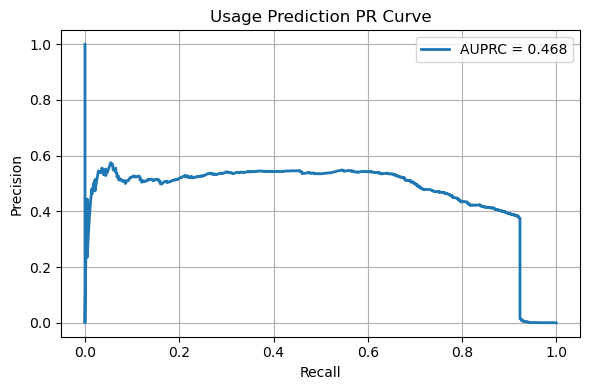

In [24]:
with torch.no_grad():
    model.eval()

threhold= plot_pr_curve(pred, target, title="Usage Prediction PR Curve")

5


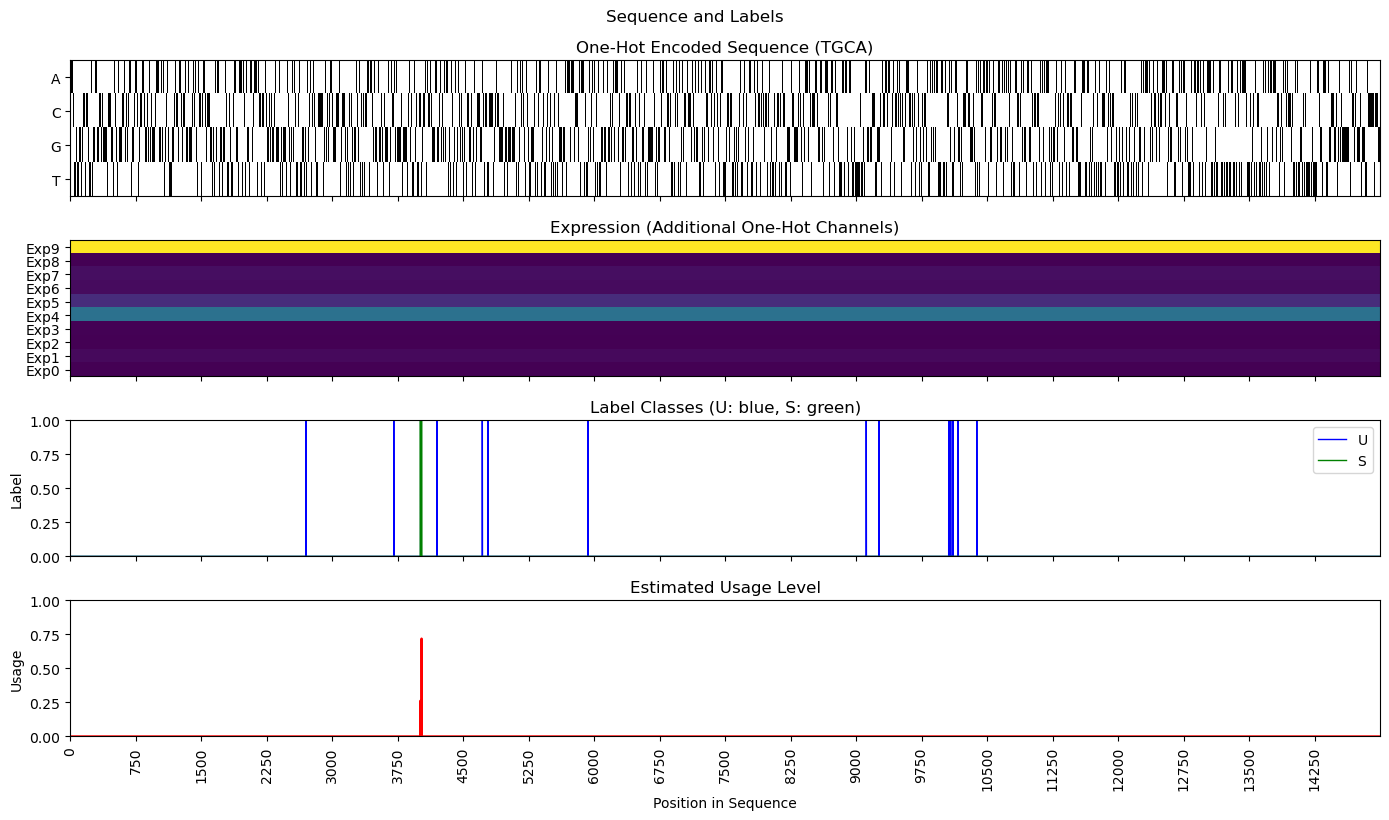

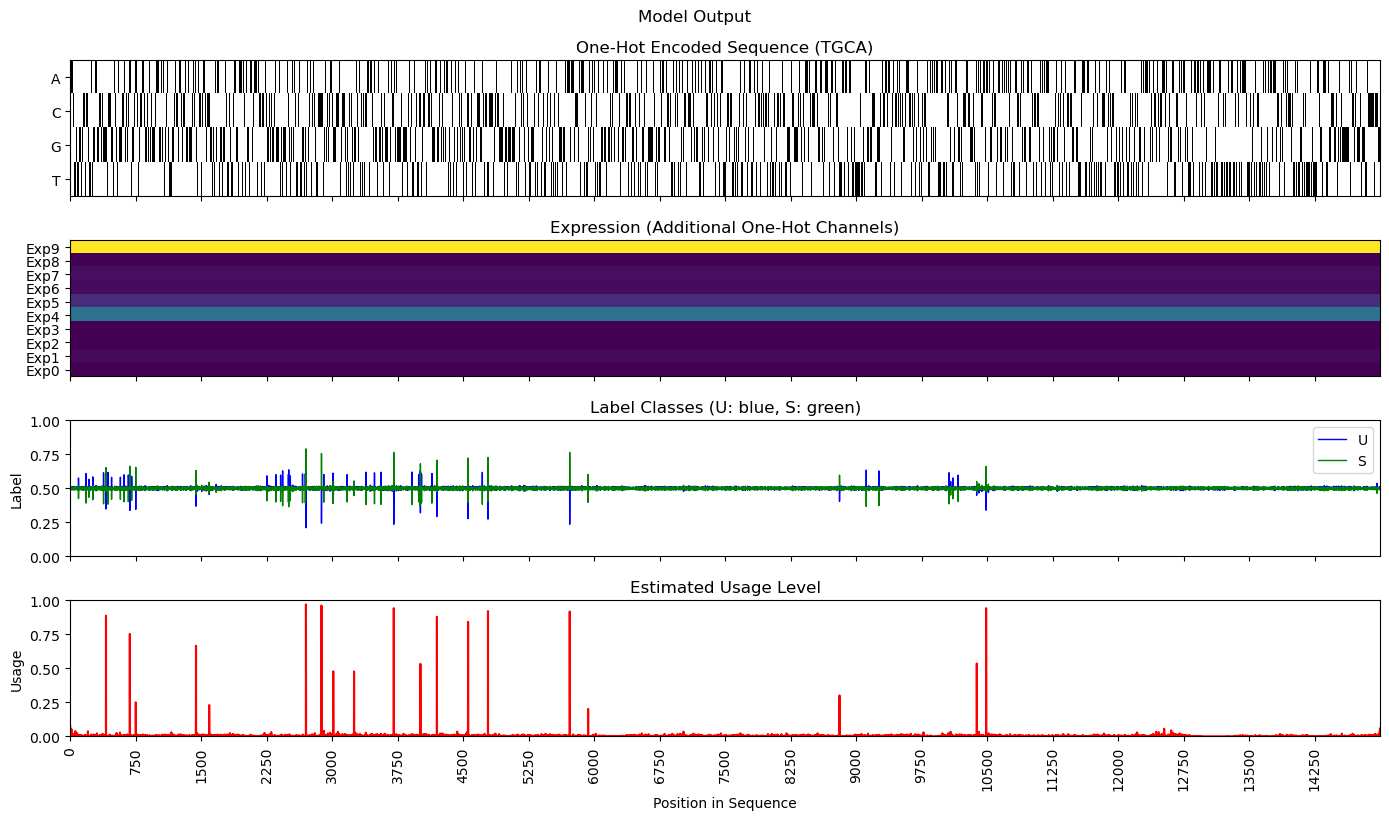

6


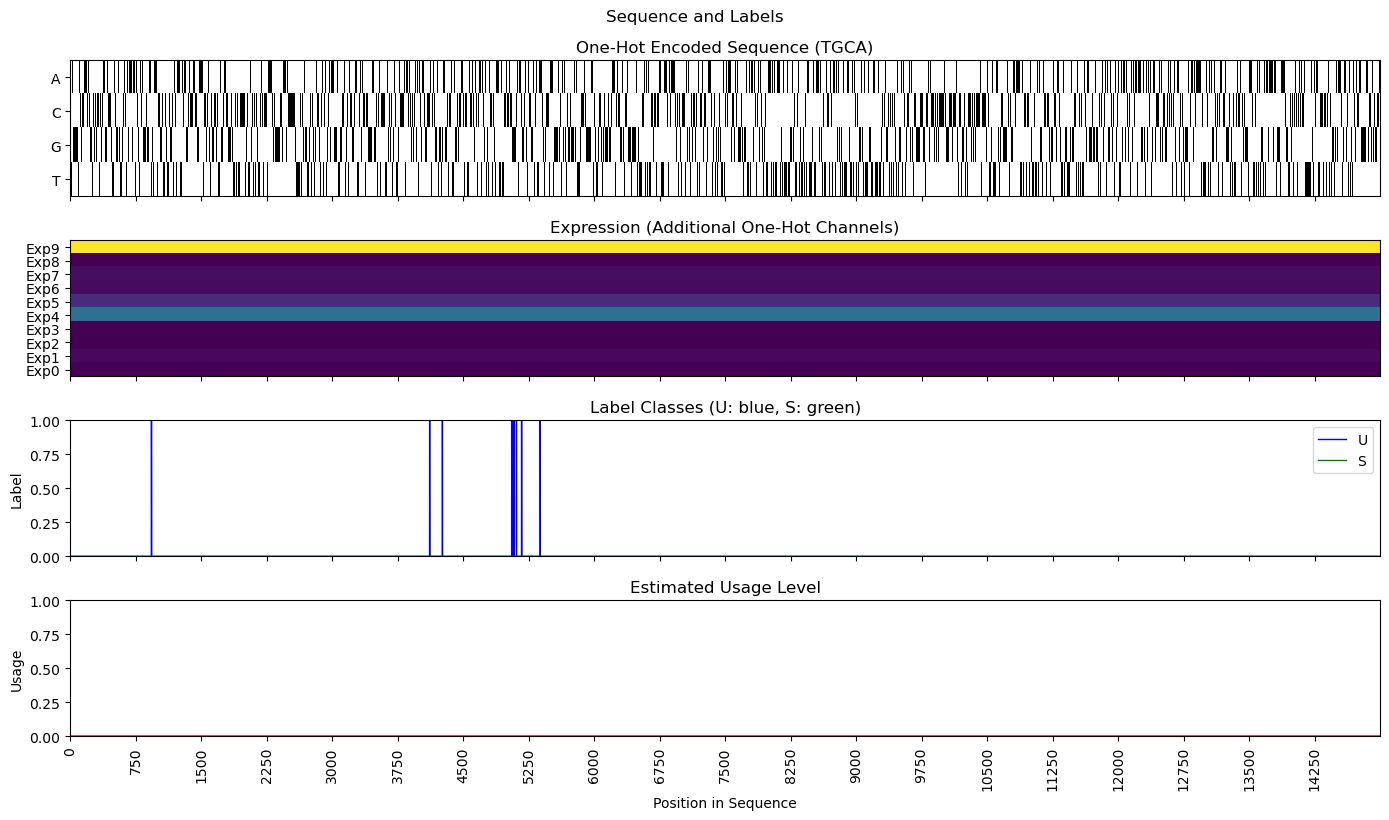

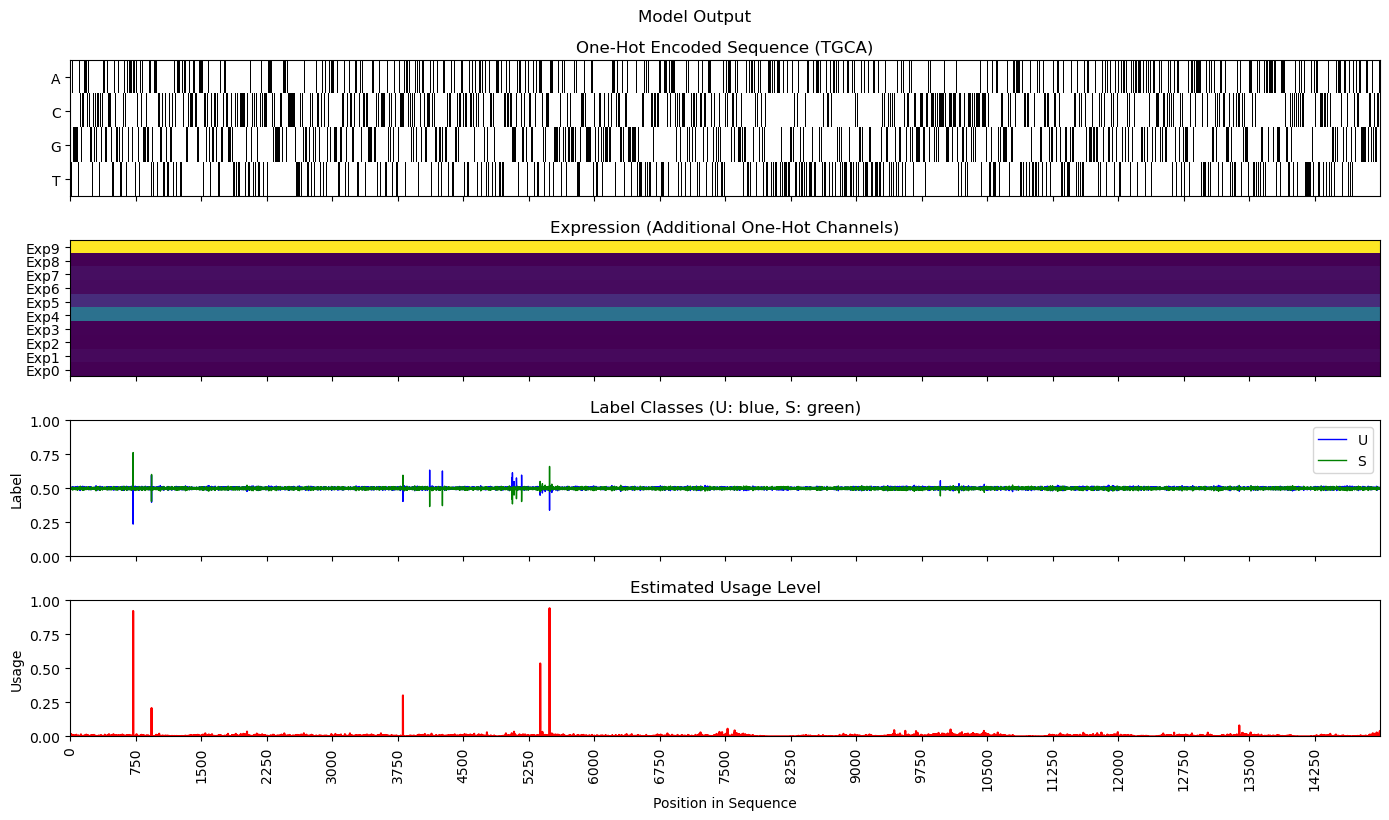

7


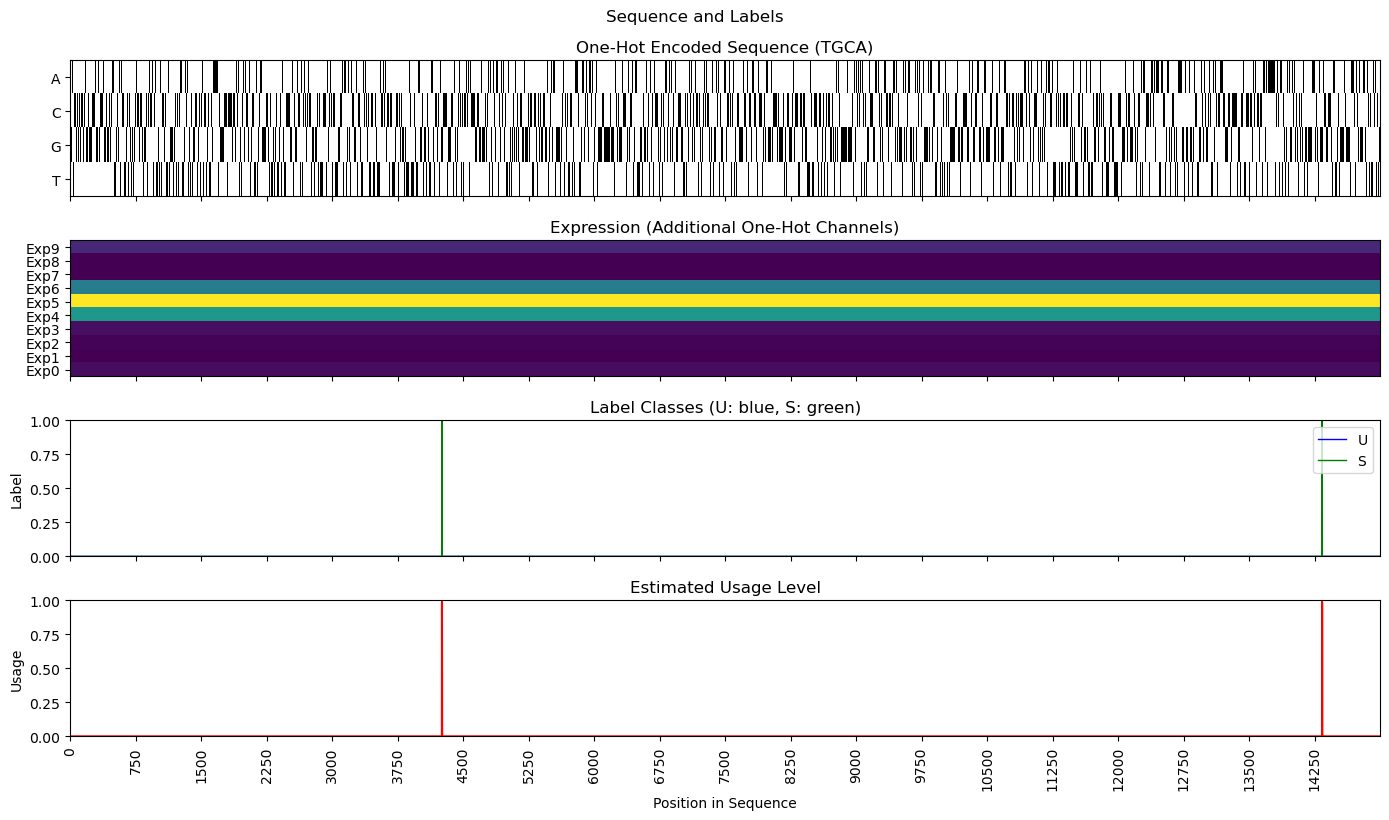

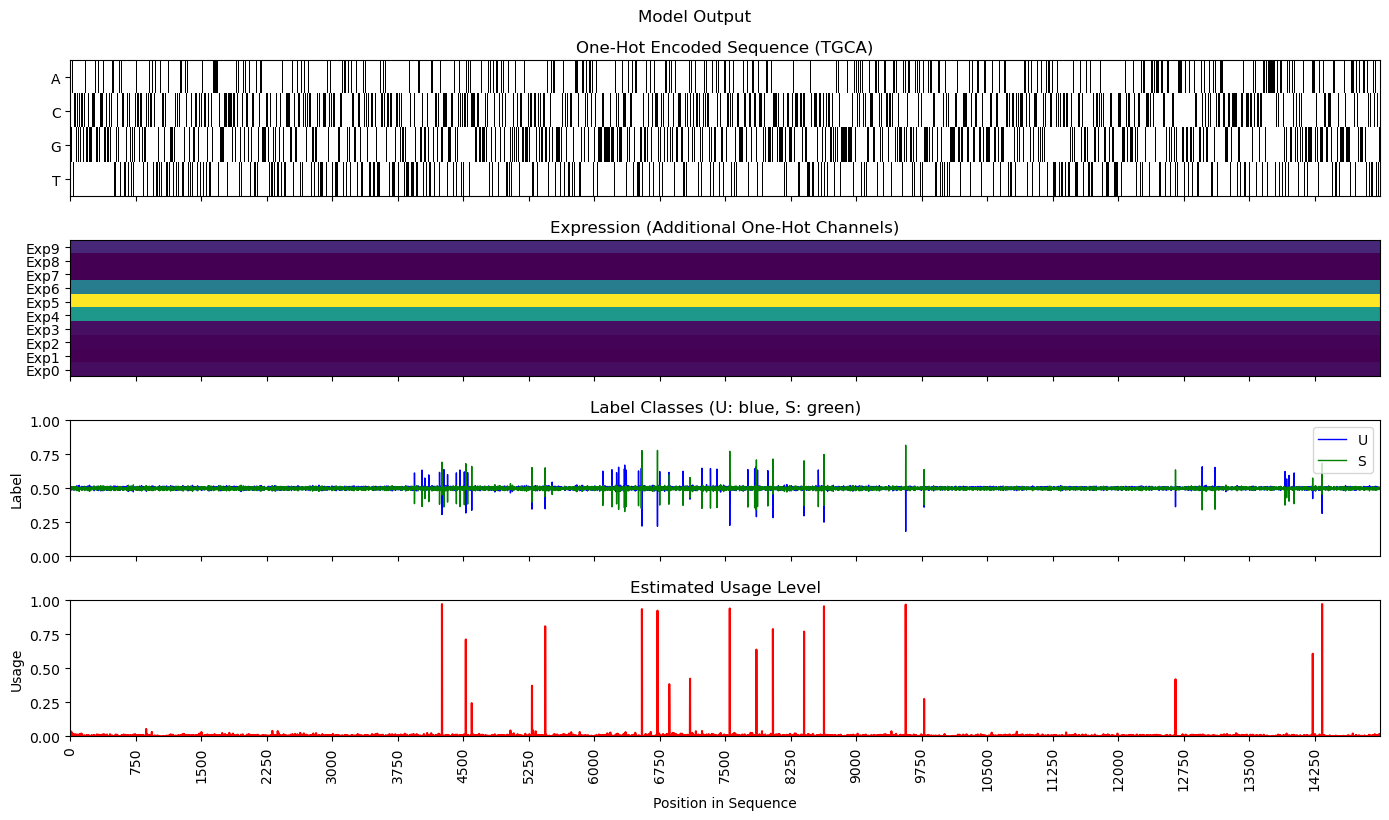

8


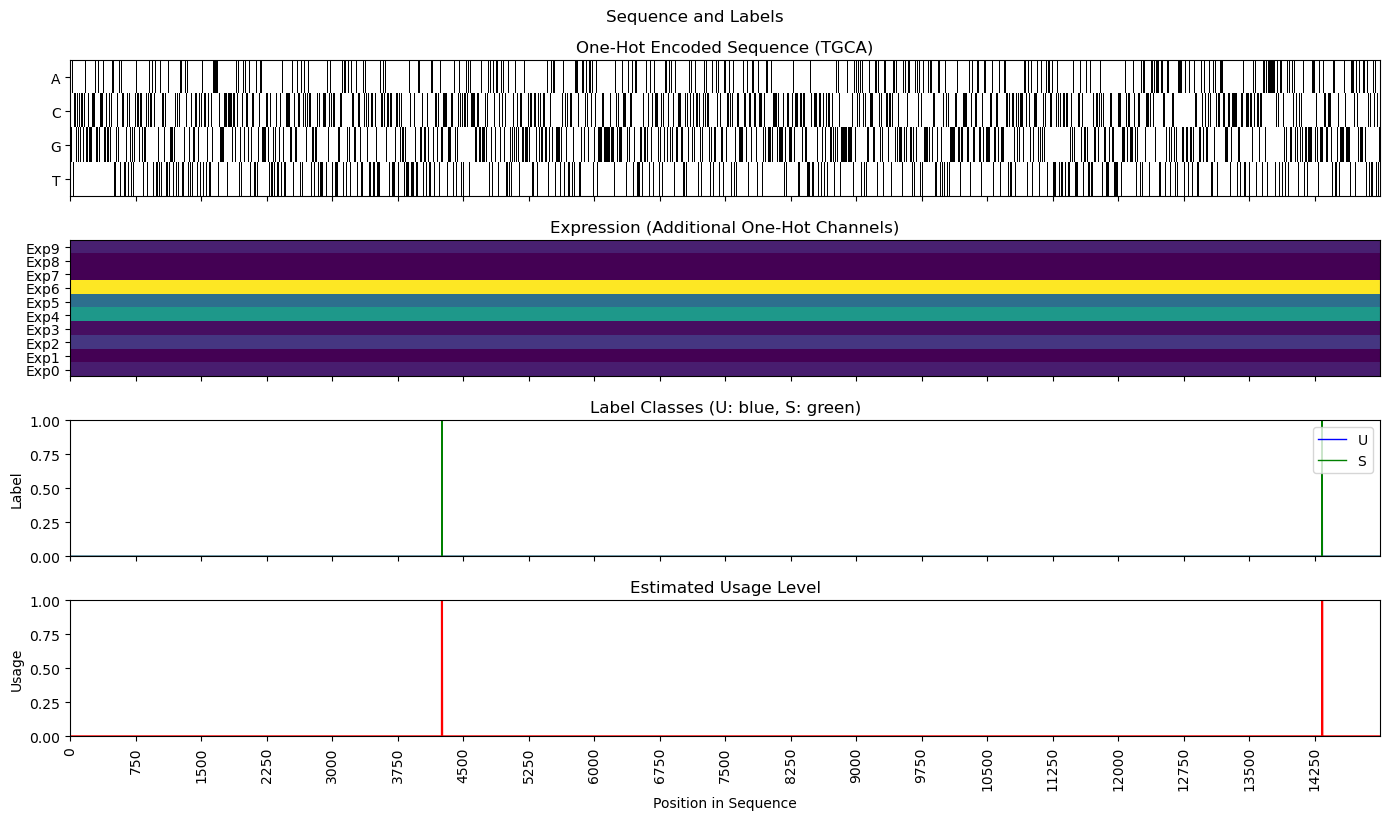

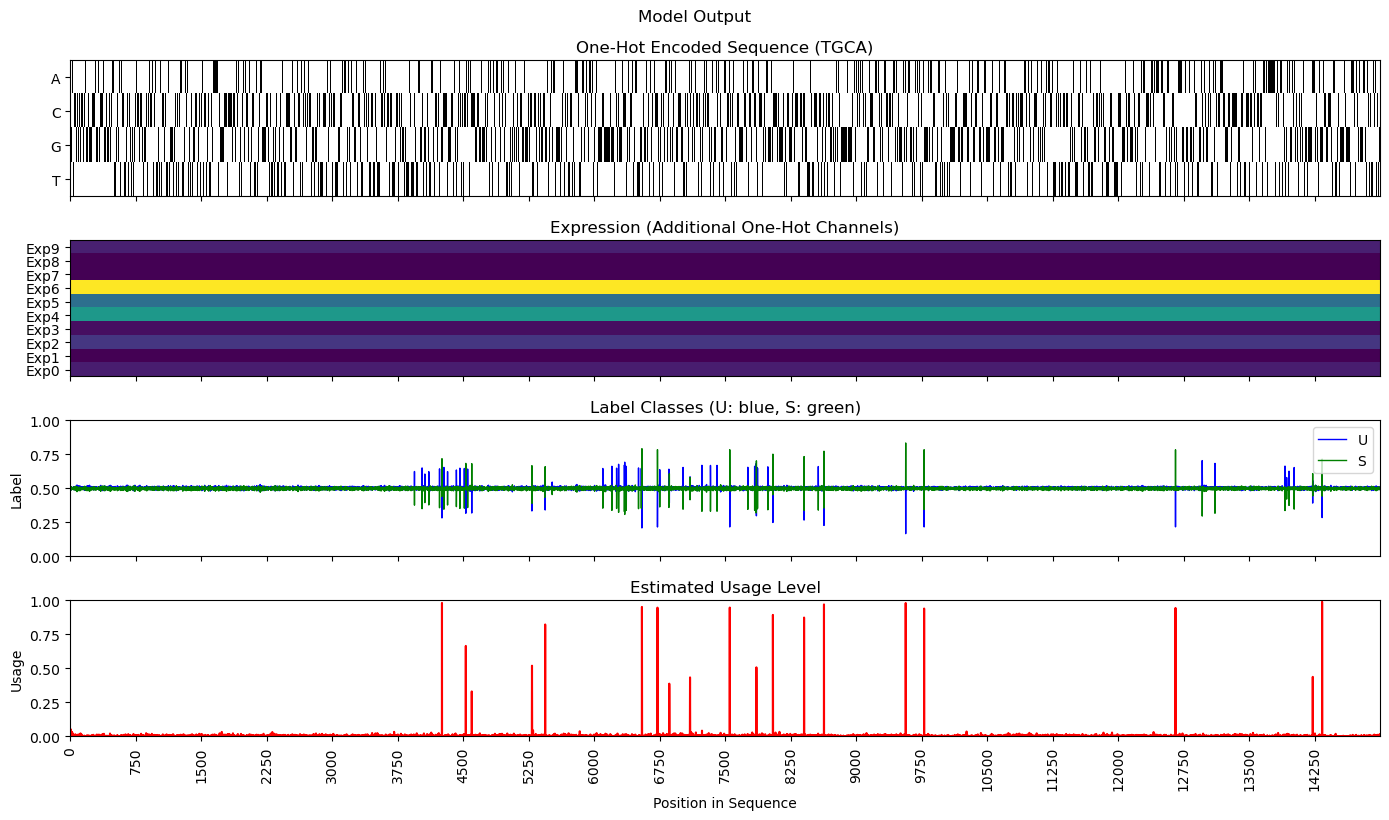

9


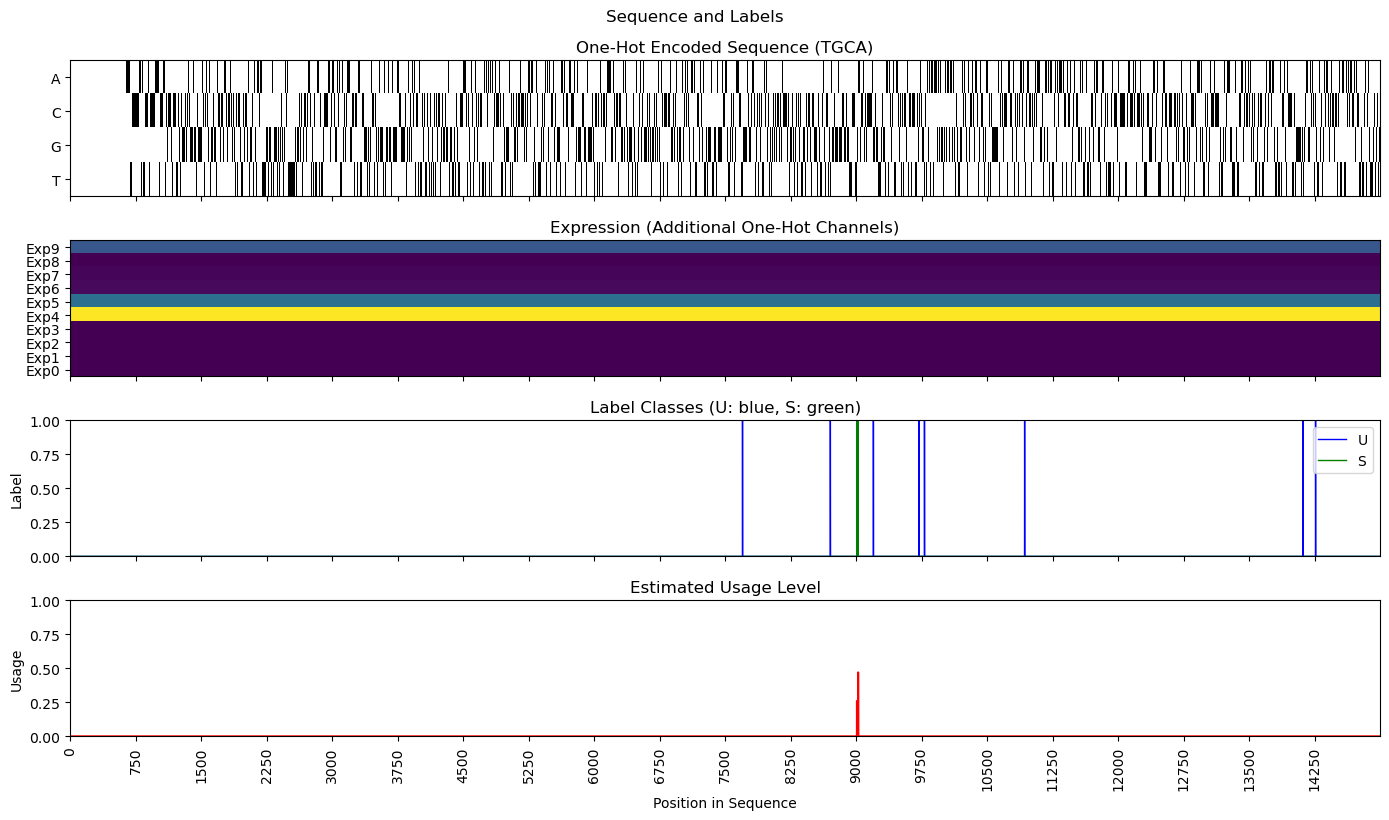

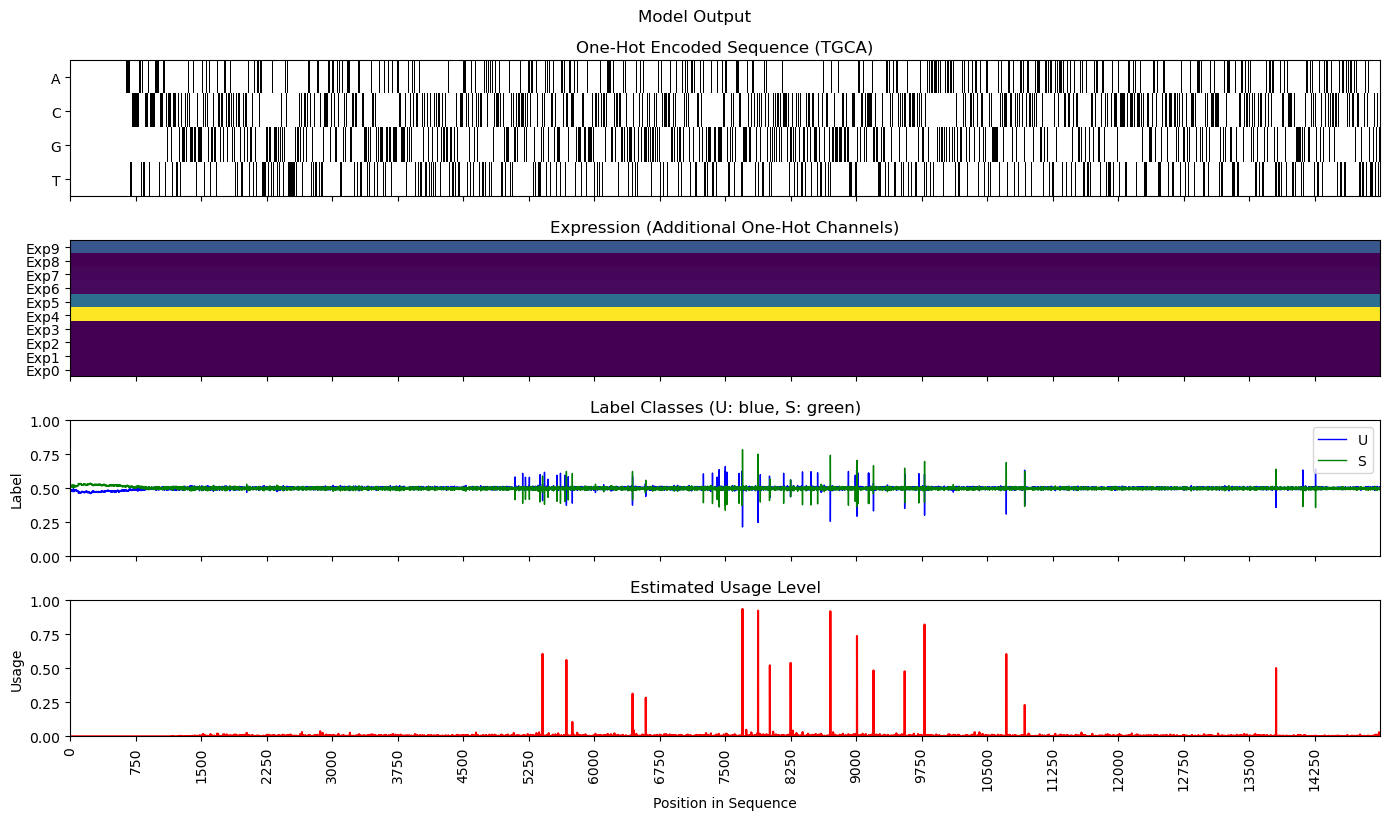

In [6]:
## BCE weight = 0
cor_start = 0
cor_end = 15000

for i in range(5, 10, 1):
    print (i)
    pad_zeros = torch.zeros_like(pred[i])
    plot_one_hot_and_labels_zoom(training_input[i], training_label[i], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")
    plot_one_hot_and_labels_zoom(training_input[i], pred[i],
                             zoom_start=cor_start, zoom_end=cor_end, title="Model Output")
    #break

5


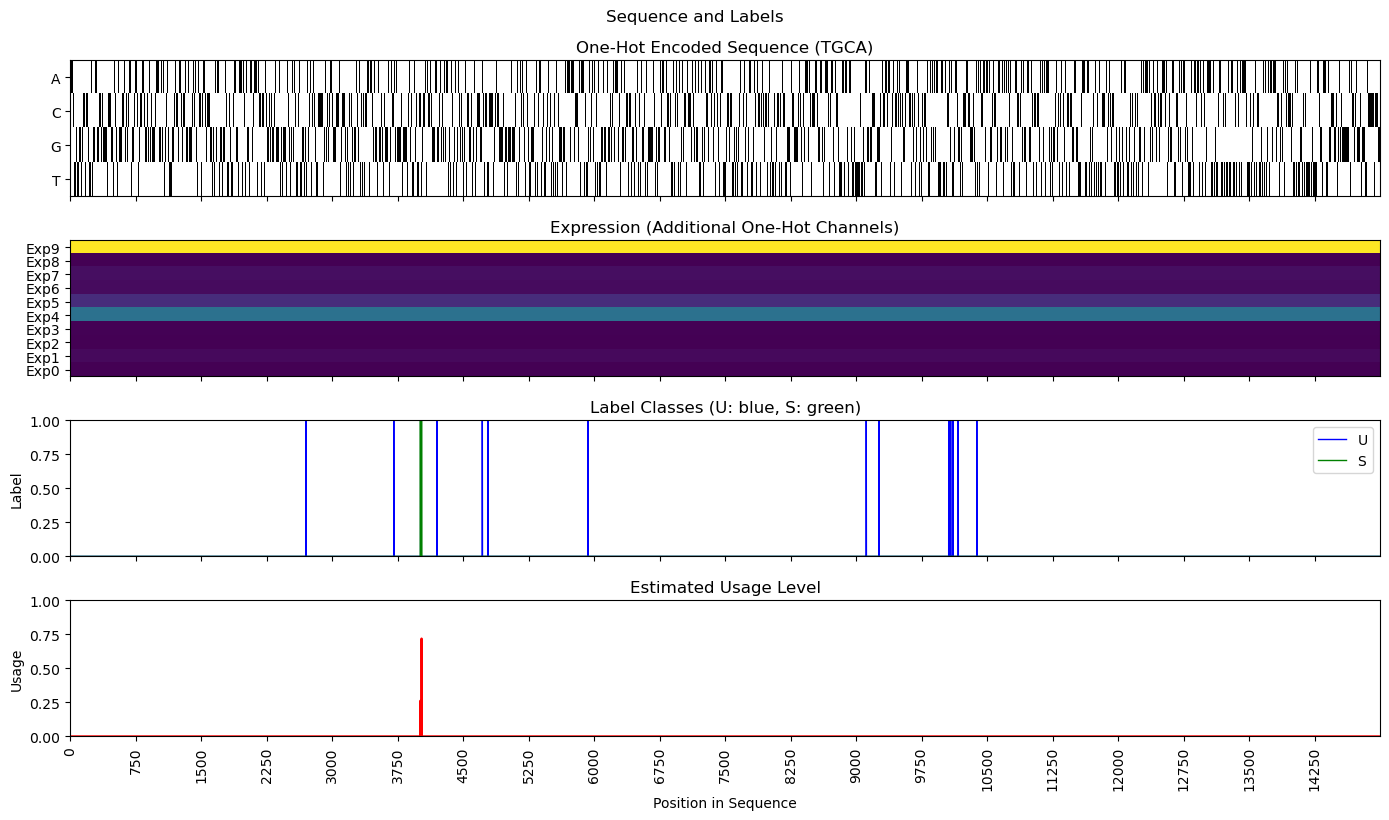

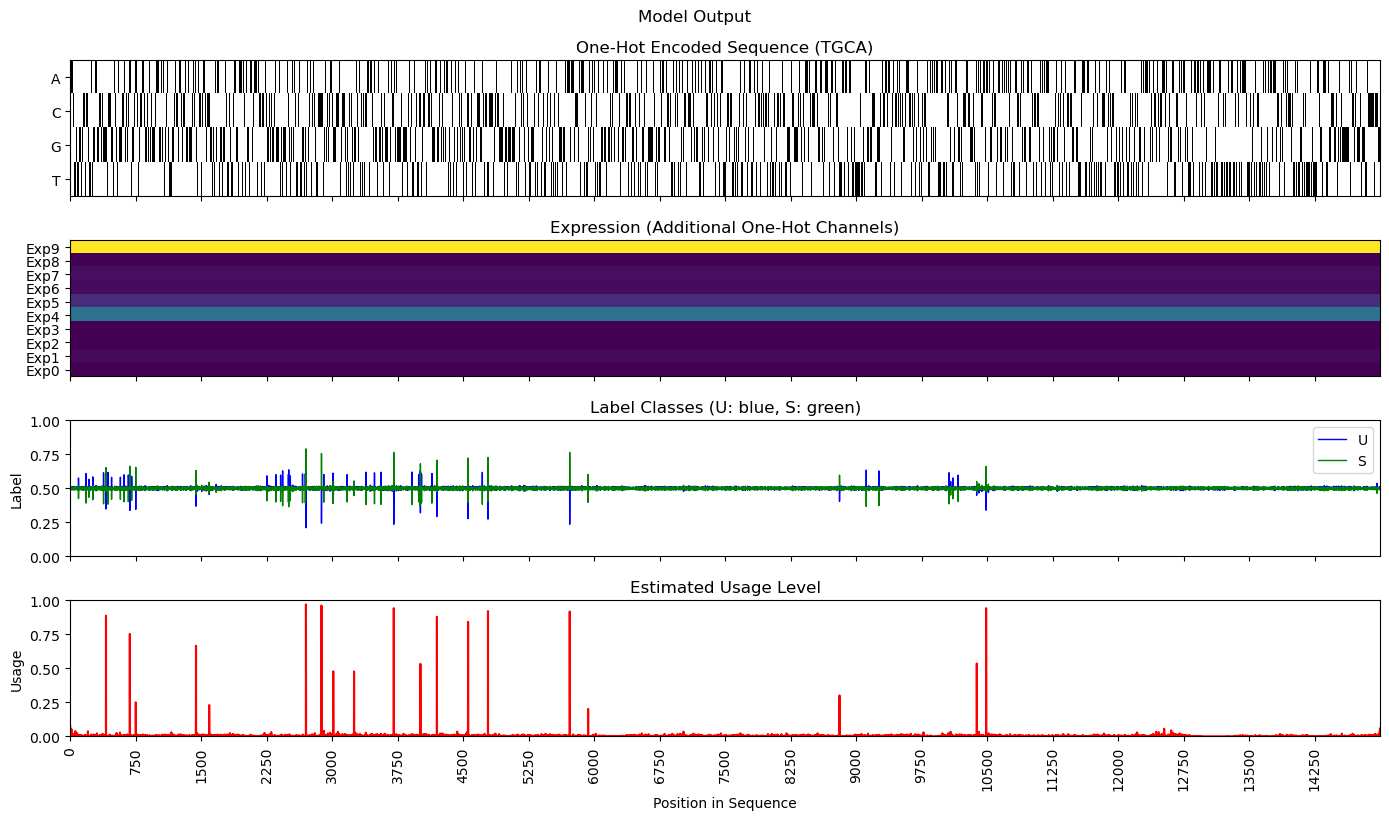

6


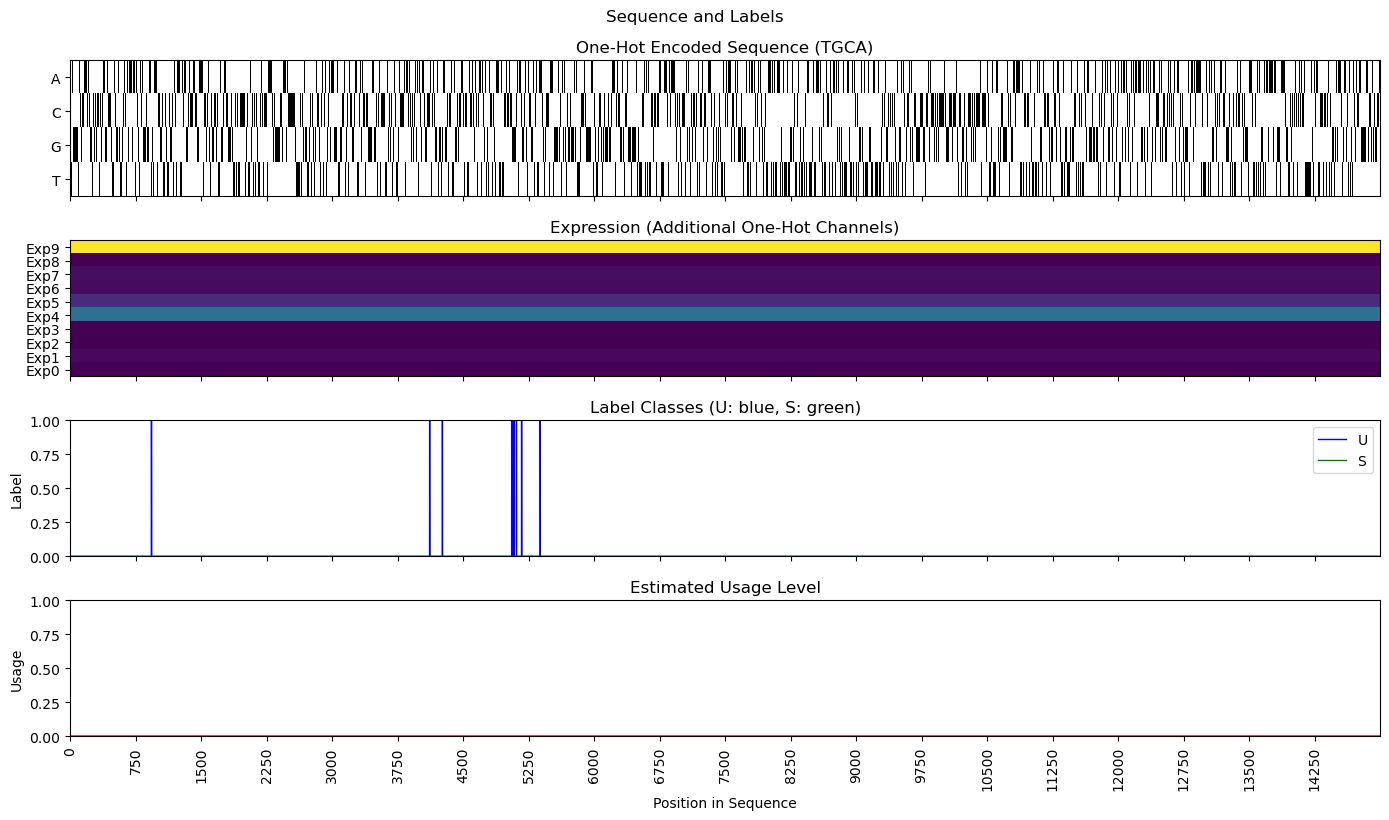

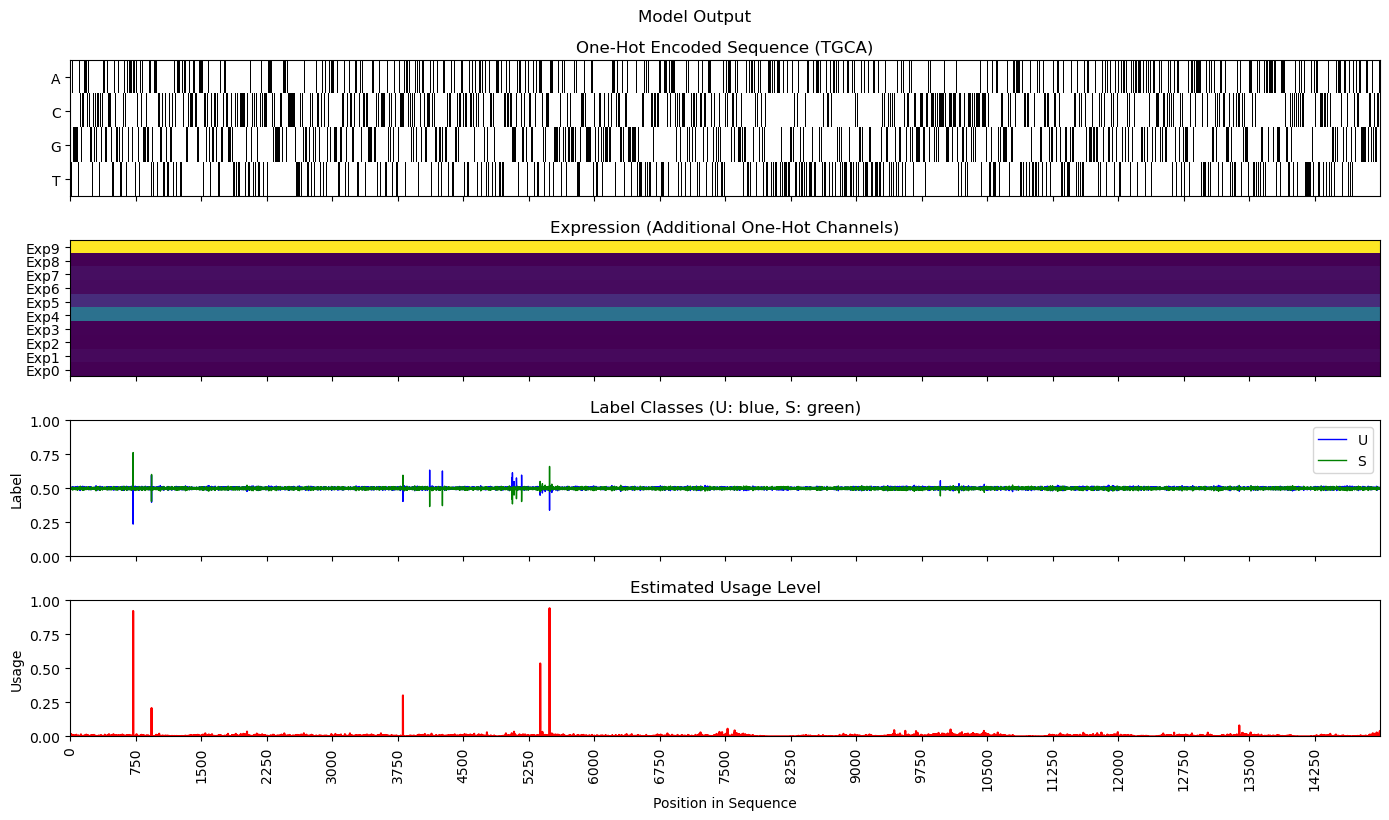

7


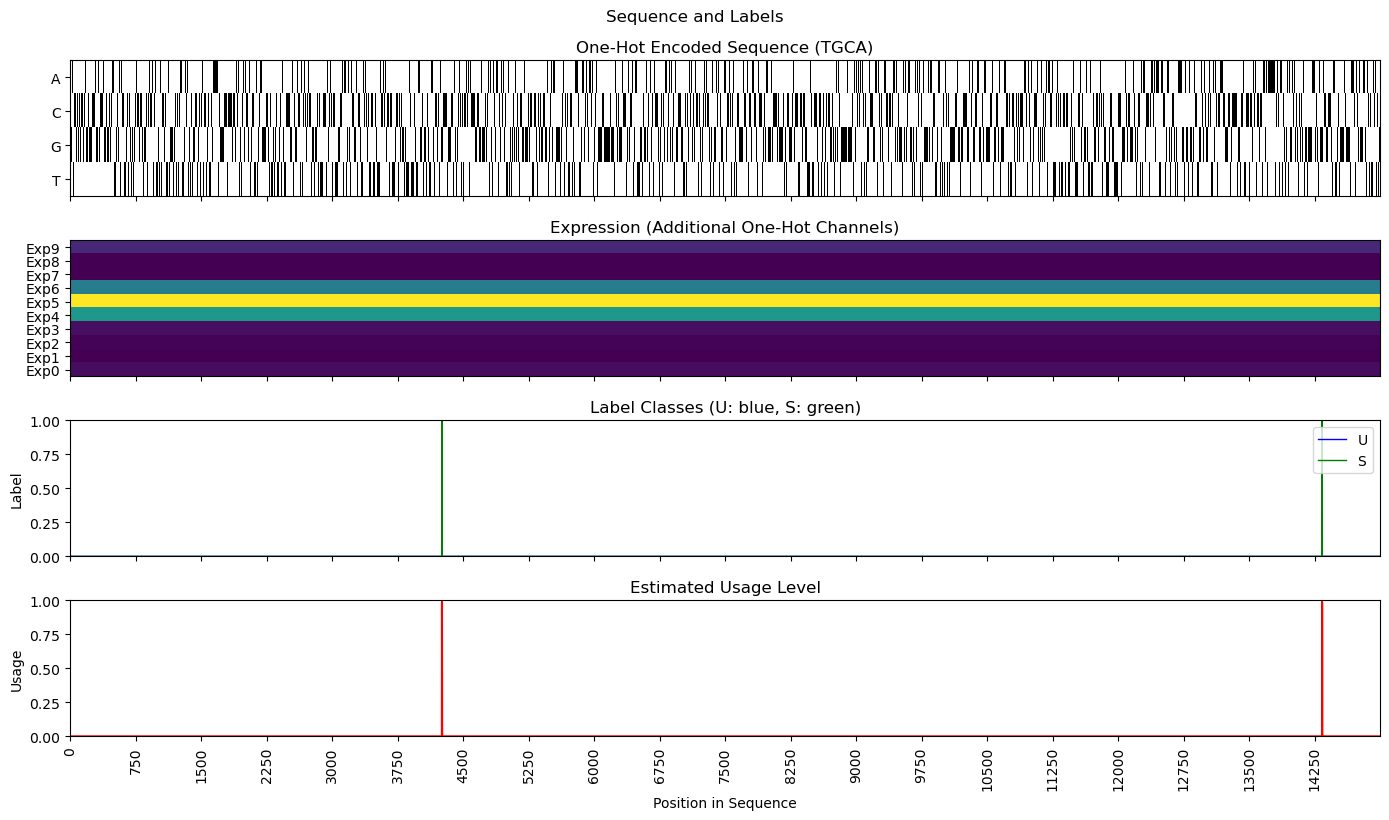

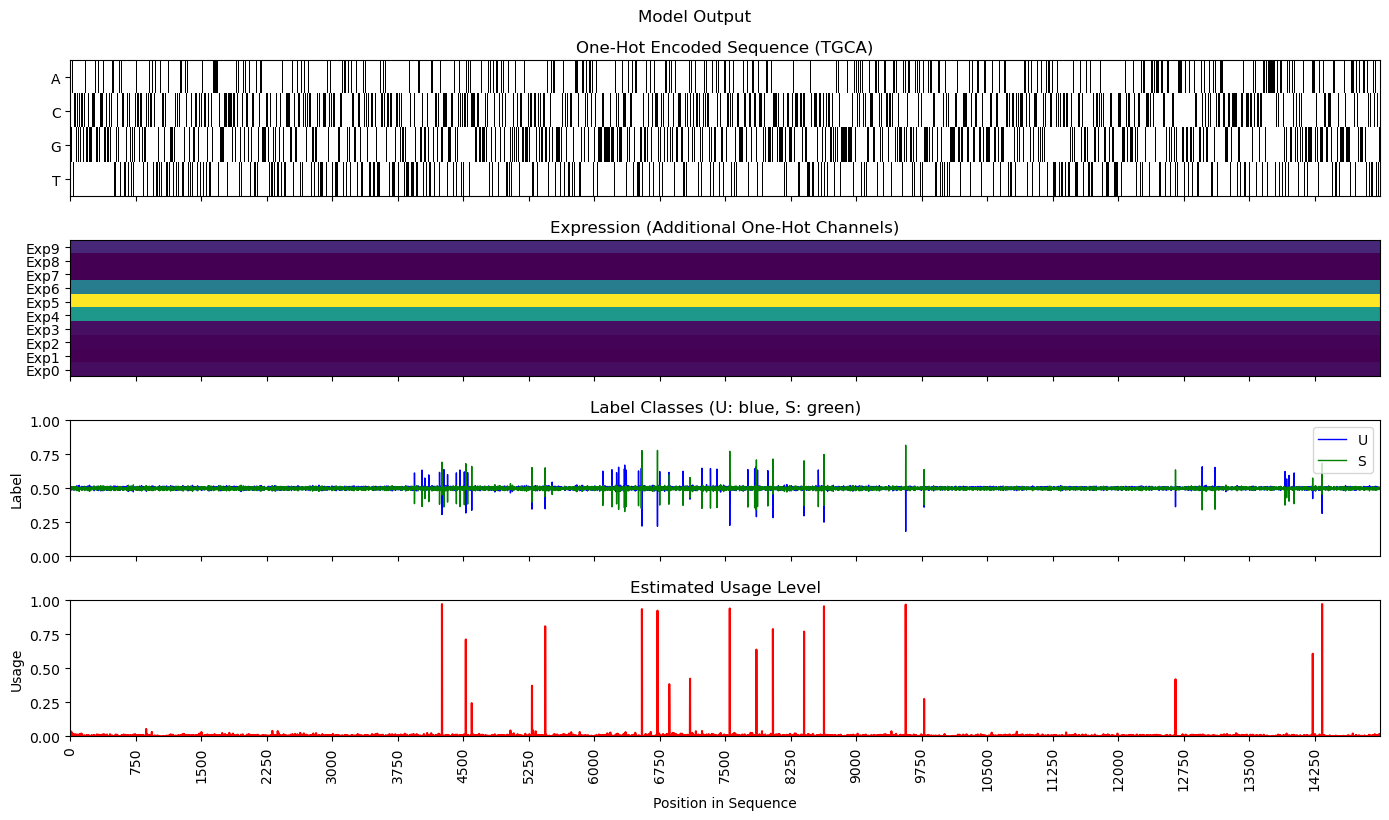

8


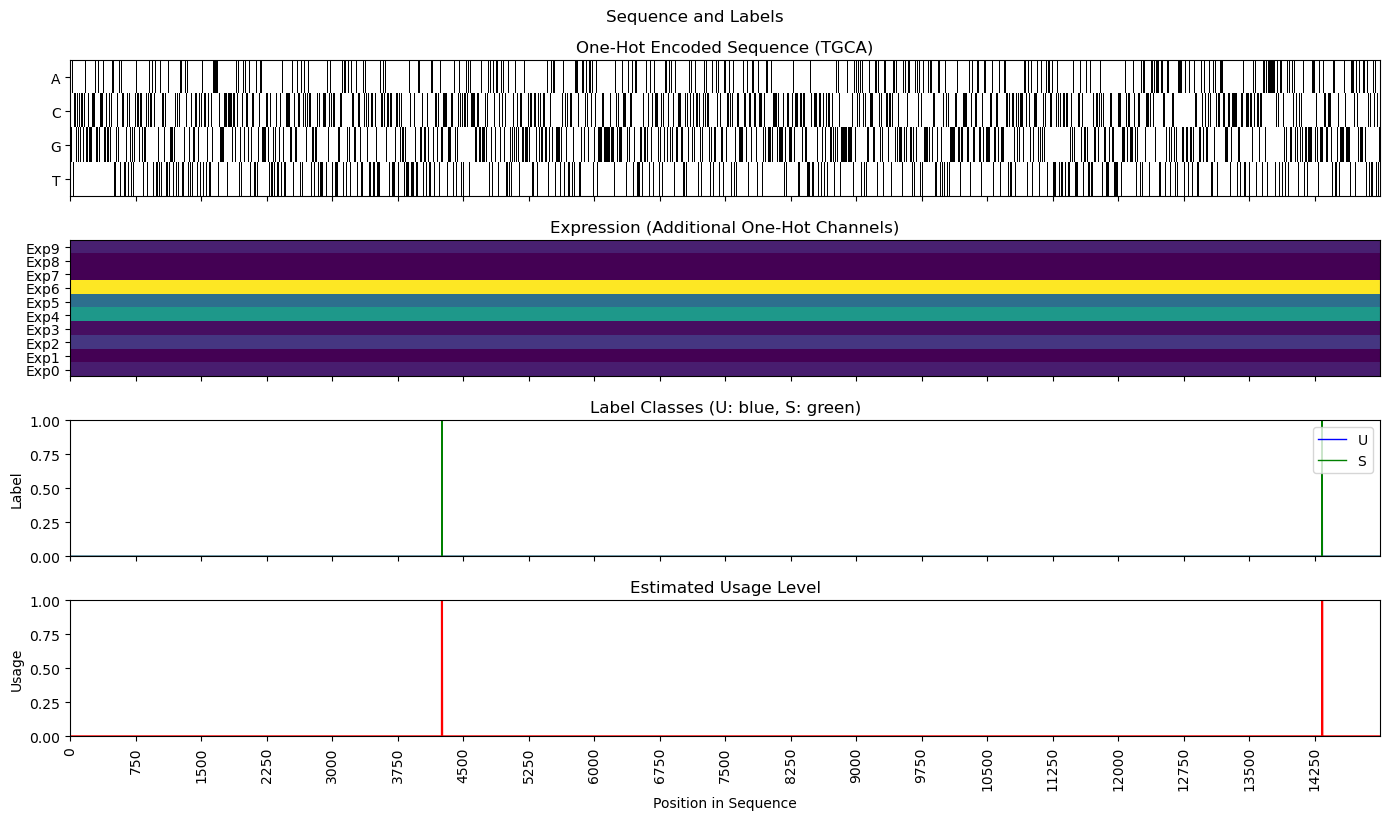

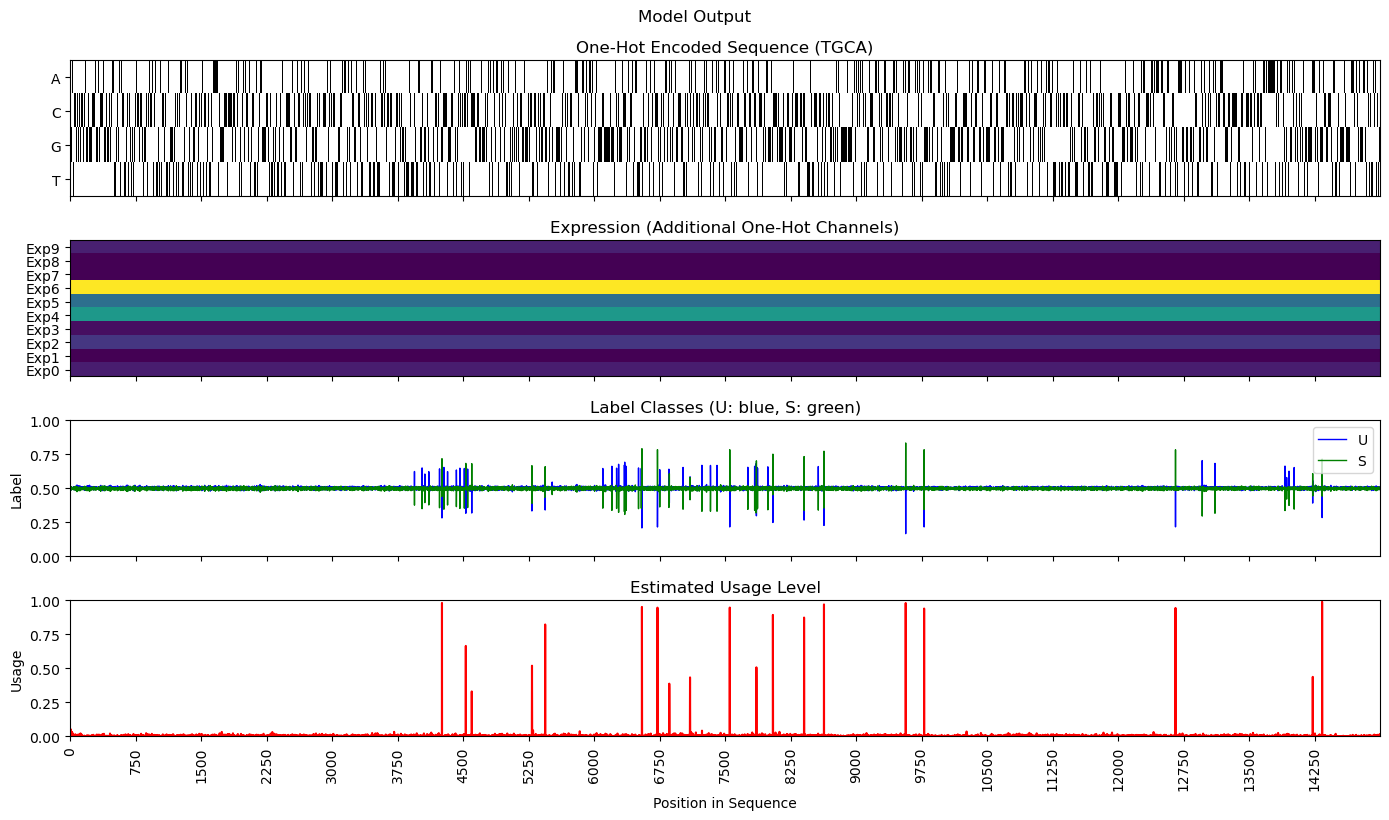

9


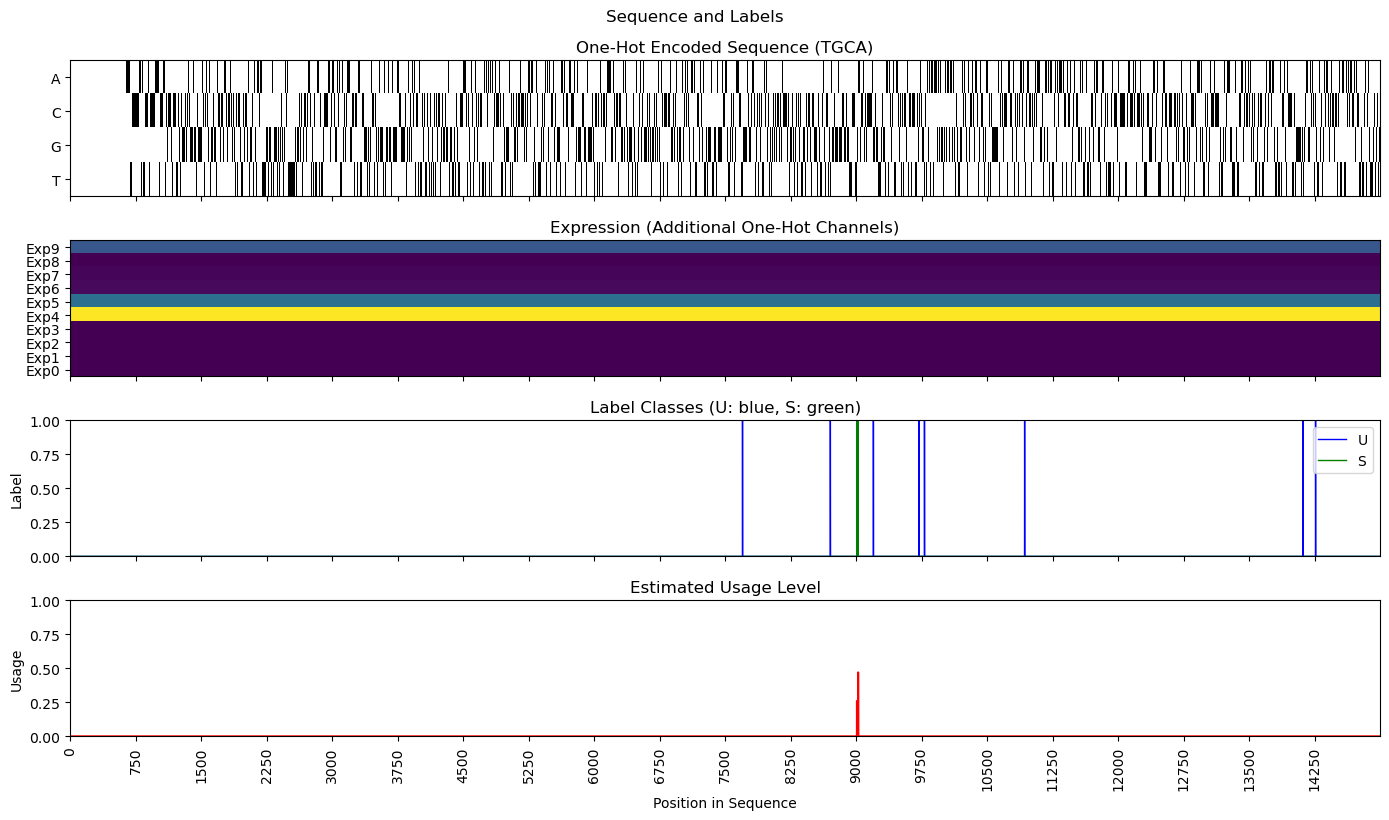

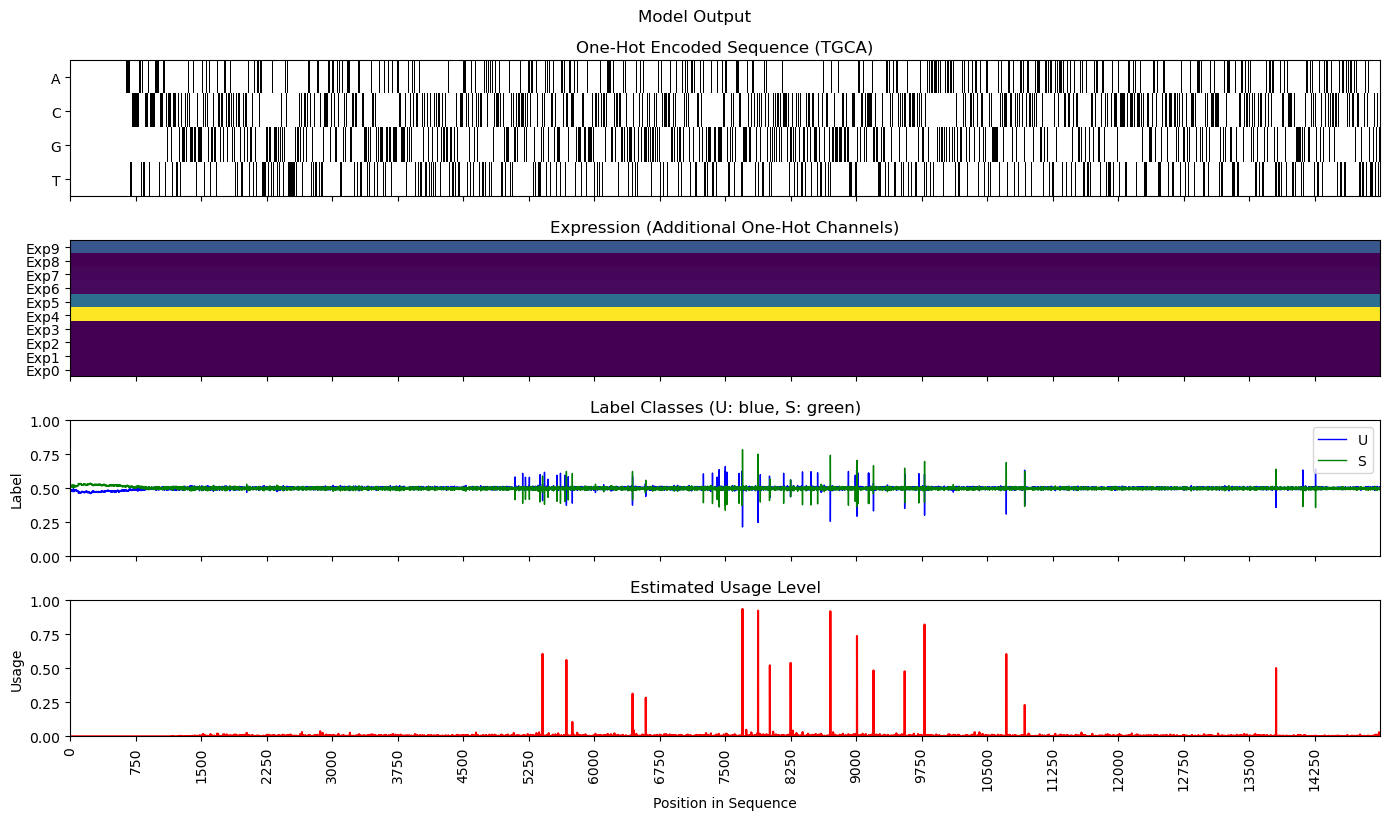

In [8]:
# hybrid lost
cor_start = 0
cor_end = 15000

for i in range(5, 10, 1):
    print (i)
    pad_zeros = torch.zeros_like(pred[i])
    plot_one_hot_and_labels_zoom(training_input[i], training_label[i], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")
    plot_one_hot_and_labels_zoom(training_input[i], pred[i],
                             zoom_start=cor_start, zoom_end=cor_end, title="Model Output")
    #break

In [20]:
#plot_one_hot_and_labels_zoom(training_input[order_select], training_label[order_select], zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")

Number of N: 0 out of 15000


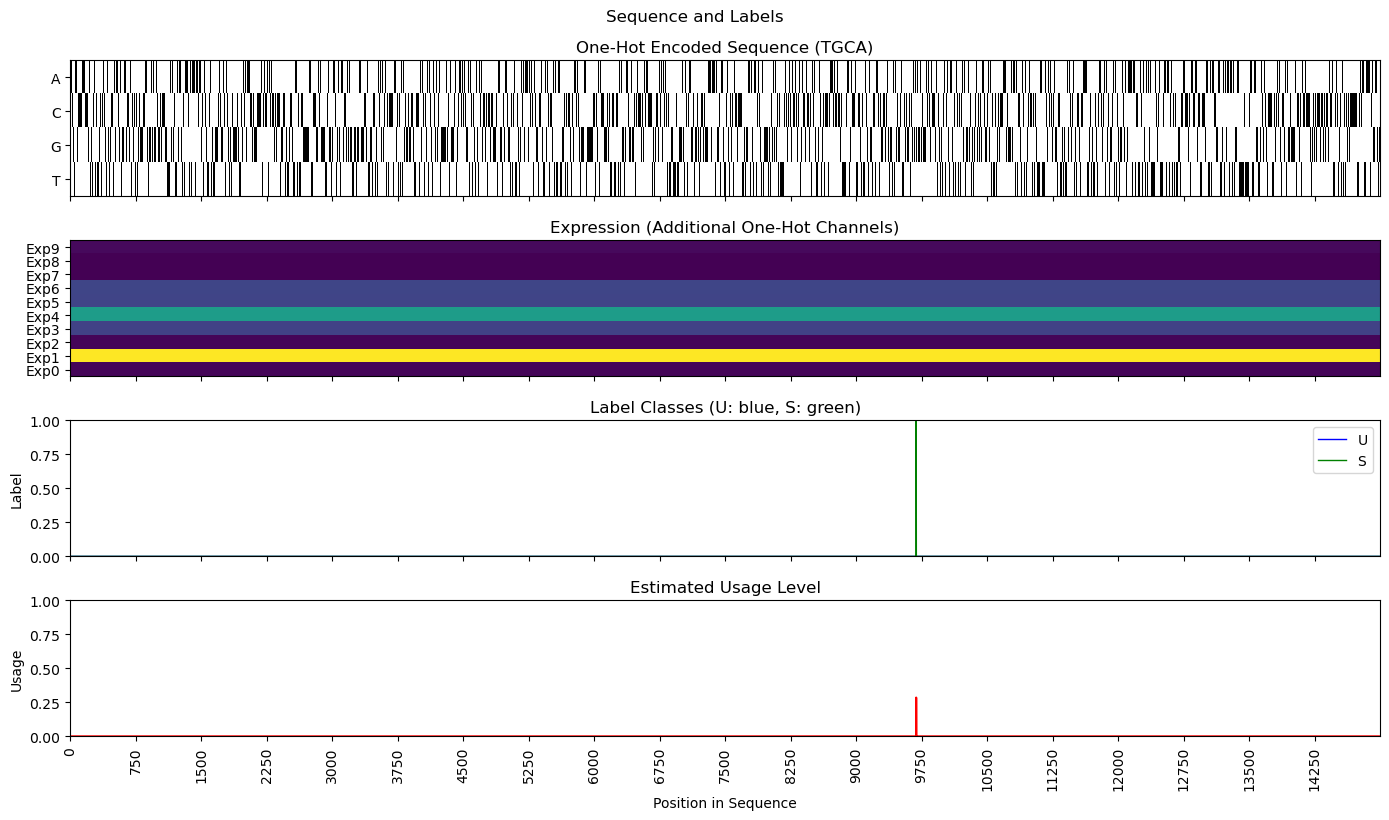

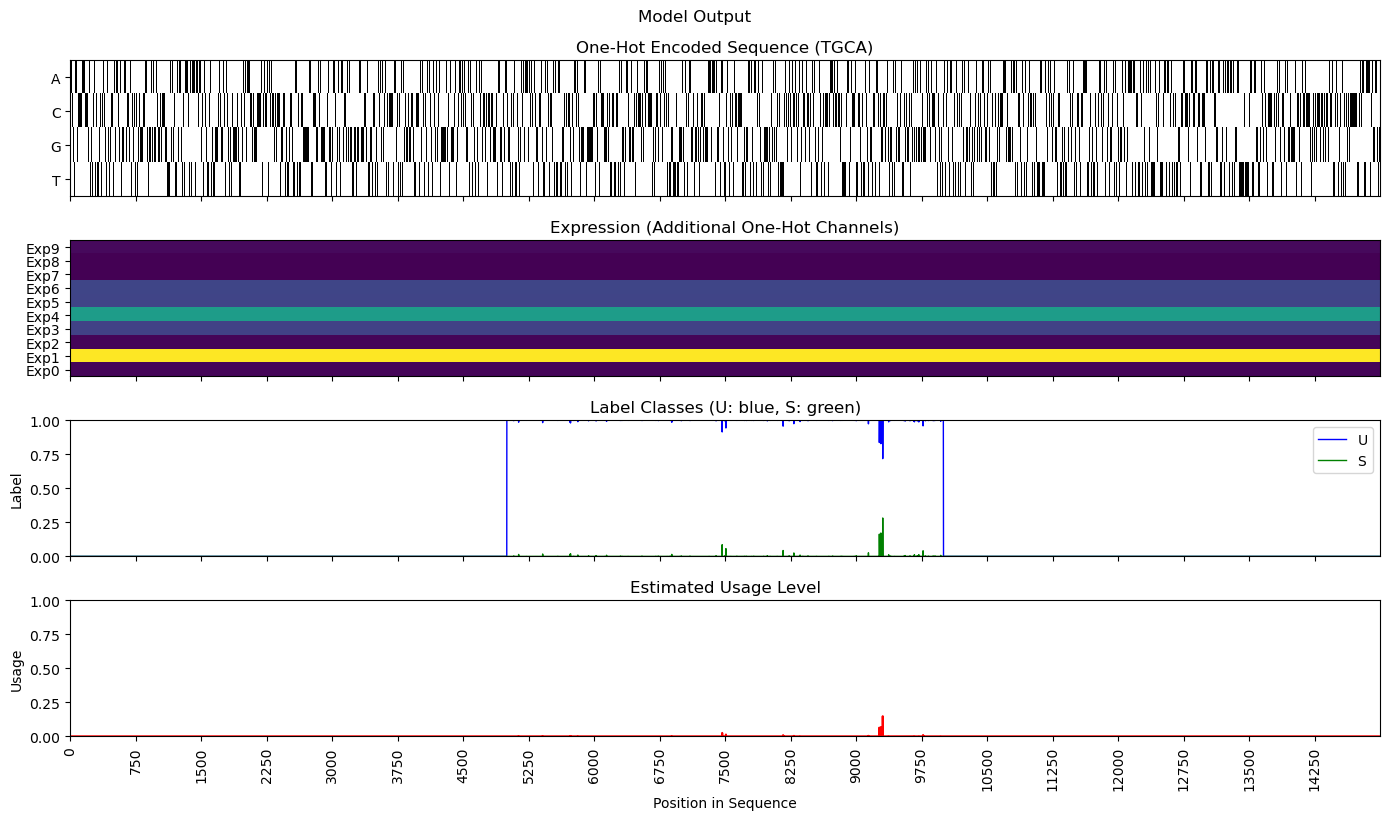

In [46]:
order_select = 7

test_data = training_input[order_select:order_select+1, :4, :].to(device)
#test_data = training_input[order_select:order_select+1, :14, :].to(device)

print("Number of N:", decode_one_hot(training_input[order_select][0:4, :]).count('N'), "out of 15000")
pred = seq_model(test_data).detach().cpu()[0, 0:3,:]

cor_start = 0
cor_end = 15000

plot_one_hot_and_labels_zoom(training_input[order_select], training_label[order_select], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")


test_predict_coordinates = torch.cat([torch.zeros_like(pred), pred, torch.zeros_like(pred)], dim=1)
plot_one_hot_and_labels_zoom(training_input[order_select], test_predict_coordinates,
                             zoom_start=cor_start, zoom_end=cor_end, title="Model Output")

Number of N: 0 out of 15000


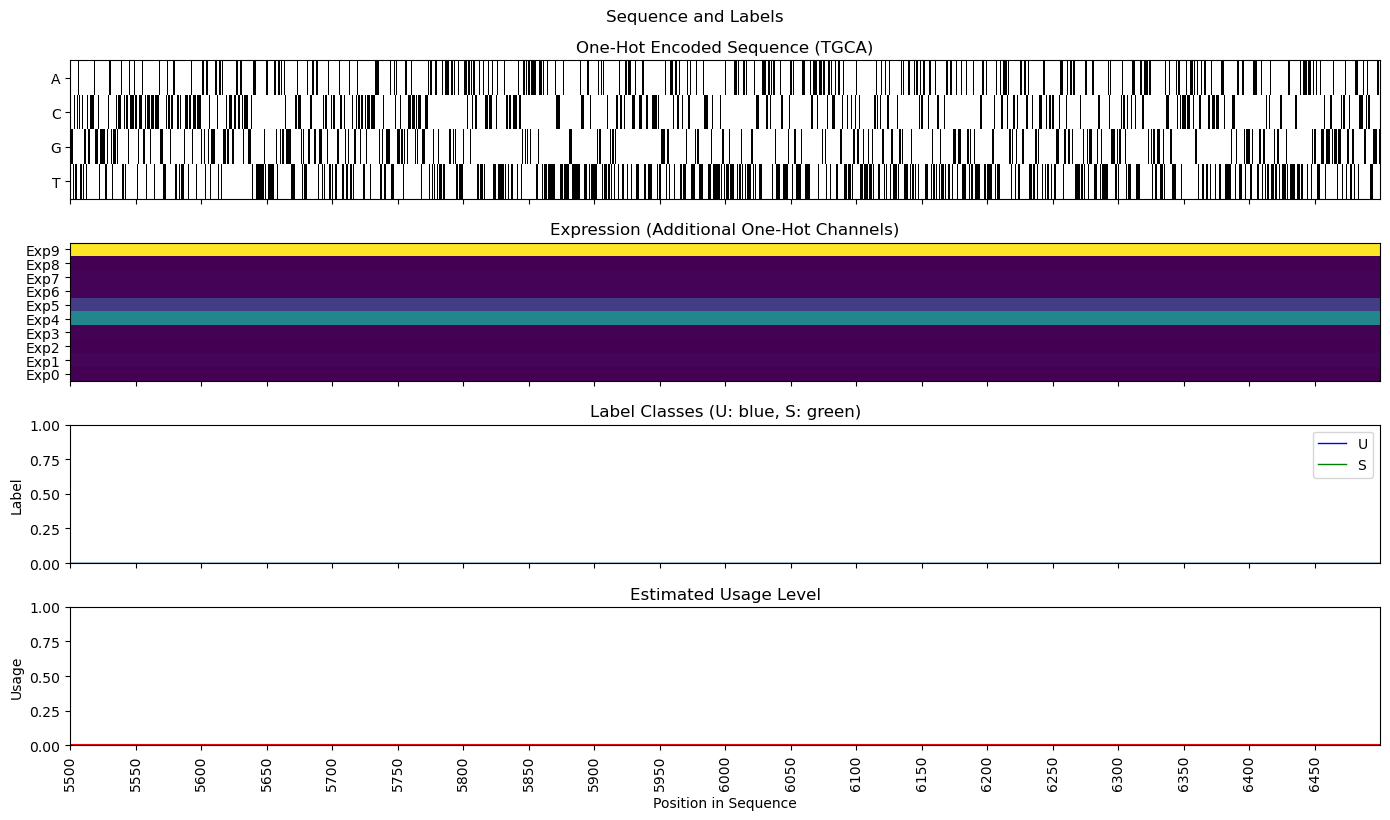

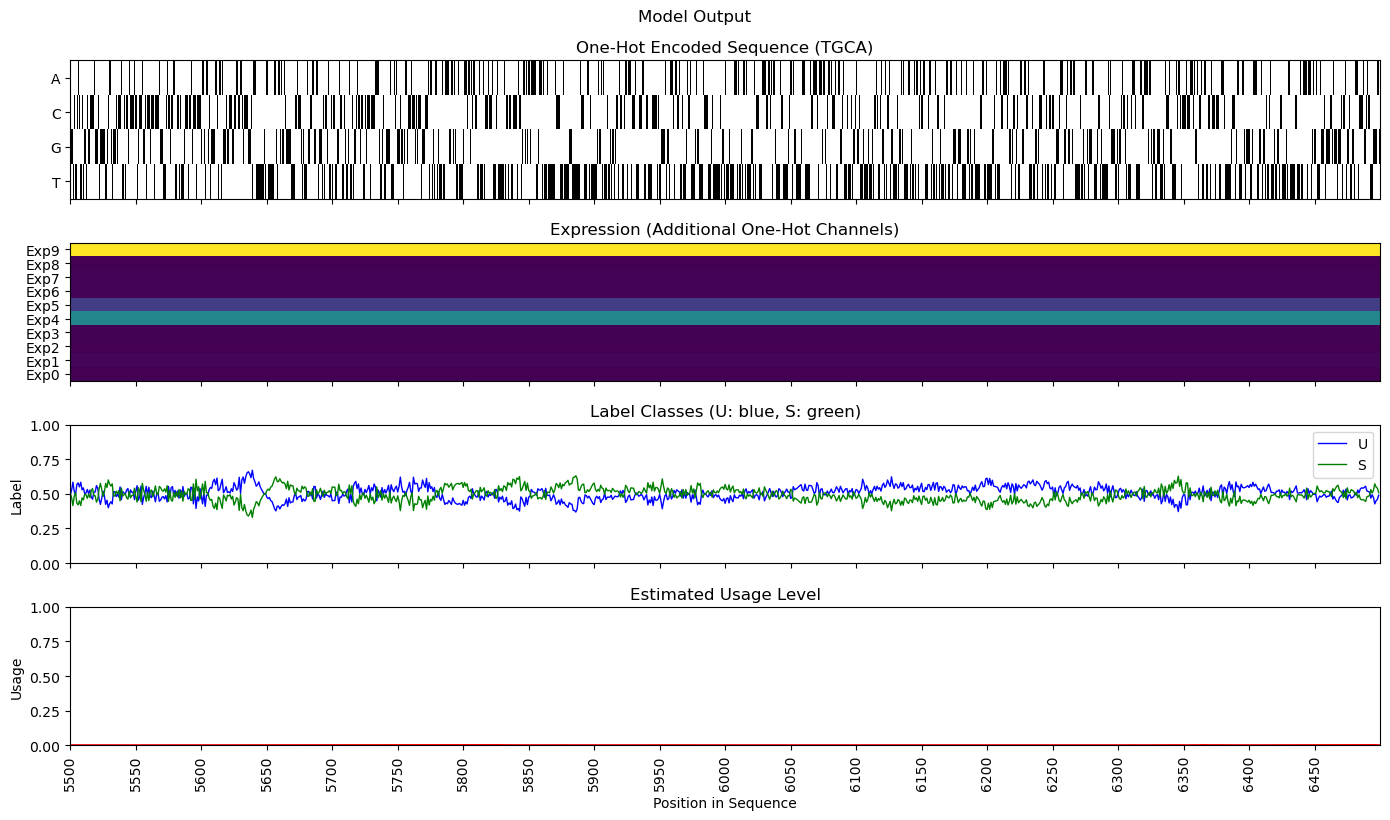

In [66]:
order_select = 0
test_data = training_input[order_select:order_select+1, :14, :].to(device)
print("Number of N:", decode_one_hot(training_input[order_select][0:4, :]).count('N'), "out of 15000")
pred = seq_model(test_data)

cor_start = 5500
cor_end = 6500

plot_one_hot_and_labels_zoom(training_input[order_select], training_label[order_select], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")


plot_one_hot_and_labels_zoom(training_input[order_select], pred.detach().cpu()[0, 0:3,:], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Model Output")

In [ ]:
#Load the Pretrained Model
seq_model = Pangolin(L=L, W=W, AR=AR)
state_dict = torch.load("Model/102_samples_sequence_exp_model.pt", map_location=device, weights_only=True)
seq_model.load_state_dict(state_dict)

# Move model to GPU################
seq_model.to(device)
###################################
# ⛳ CRITICAL: Check device of model weights
print("Model device:", next(seq_model.parameters()).device)

# Load preprocessed training data
data = torch.load("102_training_data_sequece_exp.pt", weights_only=True)
training_input =  torch.stack(data['X'])  # Each: [N, 4, 15000] # Input:
training_label = torch.stack(data['y'])  # Each: [N, 12, 5000] # Label:

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
test_data = training_input[0:100].to(device)

#og_output = og_model(input_data)

In [11]:
test_data[0].shape

torch.Size([4, 15000])